In [1]:
from datetime import datetime, timedelta
import intake

import matplotlib.pyplot as plt

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/catalog.yaml")


In [2]:
# --- SURFACE WEATHER STATION
wxt = cat.BCO.surfacemet_wxt_v1.to_dask()
wxt = wxt #.sel(time=slice('2015-01-01','2024-12-31'))  #sel(time=slice(datetime(year=2020, month=2, day=1, hour=0, minute=0), datetime(year=2020, month=3, day=1, hour=0, minute=0)) ) #slice(datetime.now() - timedelta(days=5), datetime.now())) #.plot(figsize=(12, 4));
wxt

# --- things I will need later
cp = 1004   # J / Kg K
Lv = 2.5e6  # J / Kg
grav  = 9.81   # m / s^2

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [3]:
vel  = wxt['VEL']
temp = wxt['T'] + 273.15  ## deg K
rh   = wxt['RH']/100.     ## values betwen 0 and 1
prec = wxt['R']

sfc_pressure = wxt['P']   ## already in hPa
from functions_collector import mr_from_rh

# temp is already in Kelvin
# press is already in mb
# rh was converted between 0 nd 1
q = mr_from_rh(temp, sfc_pressure, rh)

In [4]:
import xarray as xr
import numpy as np

# align to common time coordinate
# THIS IS MAGIC
temp, rh, q, vel, prec = xr.align(temp, rh, q, vel, prec, join="inner")

valid_mask = temp.notnull() & rh.notnull() & q.notnull() & vel.notnull() & prec.notnull()

vel  =  xr.where(valid_mask,  vel , np.nan)     
temp =  xr.where(valid_mask, temp , np.nan)       
rh   =  xr.where(valid_mask, rh , np.nan)       
q    =  xr.where(valid_mask,  q,   np.nan)      


# ---- compute a crude version of surface MSE
# ---- this should be a good estimator of the BL MSE
# ---- better estimates should be retrieved from Lidar
# cp = 1004   # J / Kg K
# Lv = 2.5e6  # J / Kg
# mse_sfc = cp*temp + Lv*q

prec =  xr.where(valid_mask, prec  , np.nan)    

common_times = prec.dropna(dim="time").time


print(f'VEL and Temp have same number of Nans now  : {vel.isnull().sum().values == temp.isnull().sum().values}')
print(f'Temp and Prec have same number of Nans now : {prec.isnull().sum().values == temp.isnull().sum().values}')

VEL and Temp have same number of Nans now  : True
Temp and Prec have same number of Nans now : True


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: Run

In [5]:
## SELECT CONTINUOUS TIME SERIES OF Non-Nans

import pandas as pd
from scipy.ndimage import gaussian_filter1d
from functions_collector import gaussian_filter_nan



mask = vel.notnull()
mask = mask.to_pandas()

# ---- this ensures the mask is 1D
if isinstance(mask, pd.DataFrame):
    mask = mask.squeeze()

# ---- Step 2: Identify contiguous groups
group_id = (mask != mask.shift()).cumsum()

cleanSeries = []
for g, group in mask.groupby(group_id):
    if group.iloc[0]:  # True segment
        start = group.index[0]
        end = group.index[-1]
        duration = end - start
        duration_hr = pd.Timedelta(duration) / pd.Timedelta(hours=1)
        event_wind = vel.sel(time=slice(start, end))
        cleanSeries.append({"start": start,\
                       "end": end, \
                       "duration_hr": duration_hr, \
                       }
                           )


cleanSeries_df = pd.DataFrame(cleanSeries).sort_values(by="duration_hr", ascending=False).reset_index(drop=True)
cleanSeries_df


,start,end,duration_hr
0,2018-05-09 22:54:20,2021-04-11 04:19:10,25613.413889
1,2010-12-16 16:24:00,2012-11-14 20:50:30,16780.441667
2,2023-05-06 19:00:40,2024-12-09 17:30:00,13990.488889
3,2012-11-14 20:50:50,2013-11-08 17:45:10,8612.905556
4,2013-11-23 19:05:40,2014-09-21 16:37:50,7245.536111
...,...,...,...
2541,2023-04-25 09:53:40,2023-04-25 09:53:40,0.000000
2542,2023-04-25 09:51:50,2023-04-25 09:51:50,0.000000
2543,2023-04-25 09:47:10,2023-04-25 09:47:10,0.000000
2544,2023-04-27 15:24:10,2023-04-27 15:24:10,0.000000


/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/dask/_task_spec.py:759: Run

In [6]:
# --- from Bjorn's suggestion, draw pdf of wind speed in JASO
intervals = cleanSeries_df.loc[:40, ["start", "end"]]   # rows 0,1,2

import numpy as np
import xarray as xr

# - here I concatenate the longest time series together
time = vel.time  # all datasets share the same time coordinate
ASO = [7,8,9,10]

mask = np.zeros(time.size, dtype=bool)
for _, row in intervals.iterrows():
    mask |= (time >= row["start"]) & (time <= row["end"])


vel_sel  = vel.sel(time=time[mask])
temp_sel = temp.sel(time=time[mask])
q_sel    = q.sel(time=time[mask])
prec_sel = prec.sel(time=time[mask])


In [14]:
def weighted_pdf(x,weight):

    ## inputs: 
    ## x,y Xarrays with ALIGNED TIME DIMENSION
    percentiles = xr.DataArray(np.arange(0,1.02,0.02))
    bins_x = x.quantile(percentiles).values

    # total precip per wind-speed bin
    weight_per_bin_ws = weight.groupby_bins(x, bins=bins_x).sum()

    # bin widths
    bin_widths = xr.DataArray(
        np.diff(bins_x),
        dims=weight_per_bin_ws.dims
    )

    # normalize → PDF
    pdf_x = weight_per_bin_ws / (weight_per_bin_ws.sum() * bin_widths)

    # bin centers
    centers_x = 0.5 * (bins_x[:-1] + bins_x[1:])

    return centers_x, pdf_x

In [7]:
# # - data selection
x_vel = vel_sel.resample(time="1h").mean()
y_mse = (cp * temp_sel + Lv * q_sel).resample(time="1h").mean()
z_prec = prec_sel.resample(time='1h').sum()

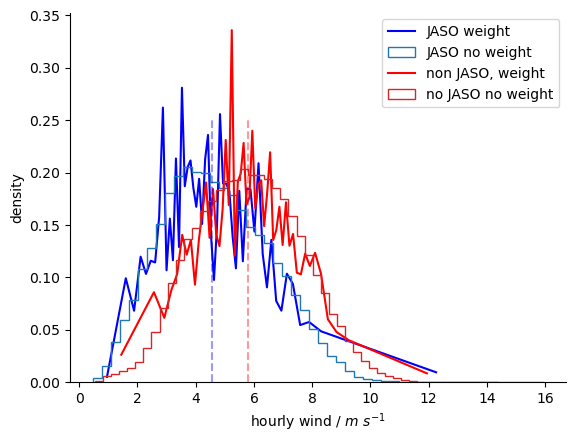

In [15]:
x_vel_ASO = x_vel.where(x_vel.time.dt.month.isin(ASO), drop=True)
z_prec_ASO = z_prec.where(z_prec.time.dt.month.isin(ASO), drop=True)

x_vel_notASO = x_vel.where(~x_vel.time.dt.month.isin(ASO), drop=True)
z_prec_notASO = z_prec.where(~z_prec.time.dt.month.isin(ASO), drop=True)


## - plotting
fig, ax = plt.subplots(1,1)

## --- ASO
v_ASO, p_ASO = xr.align(x_vel_ASO, z_prec_ASO)
centers_v_ASO, pdf_v_ASO = weighted_pdf(v_ASO,p_ASO)

ax.plot(centers_v_ASO, pdf_v_ASO, "blue", label="JASO weight")
ax.hist(v_ASO, bins=50, histtype="step", density=True, color="tab:blue", label="JASO no weight")


## --- not ASO
v_notASO, p_notASO = xr.align(x_vel_notASO, z_prec_notASO)
centers_v_notASO, pdf_v_notASO = weighted_pdf(v_notASO,p_notASO)

ax.plot(centers_v_notASO, pdf_v_notASO, "red", label="non JASO, weight")
ax.hist(v_notASO, bins=50, histtype="step", density=True, color="tab:red", label="no JASO no weight")

## - median lines
ax.vlines(x=v_ASO.quantile(0.5).values, ymin=0, ymax=0.25, color="blue", linestyle="dashed", alpha=0.4)
ax.vlines(x=v_notASO.quantile(0.5).values, ymin=0, ymax=0.25, color="red", linestyle="dashed", alpha=0.4)

for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

ax.set_ylabel("density")
ax.set_xlabel(r"hourly wind / $m~s^{-1}$")

ax.legend()
plt.show()

In [16]:
## CORAL available from 2019 to 2023

coral = cat.BCO.lidar_CORAL_LR_t_c1_v1.to_dask()
coral

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 7GB
Dimensions:    (alt: 484, lim: 2, time: 473760)
Coordinates:
  * alt        (alt) float32 2kB 20.0 80.0 140.0 ... 2.888e+04 2.894e+04 2.9e+04
  * time       (time) datetime64[ns] 4MB 2019-01-21T00:02:00 ... 2023-03-18
Dimensions without coordinates: lim
Data variables:
    alt_bnds   (alt, lim) float32 4kB dask.array<chunksize=(484, 2), meta=np.ndarray>
    dtadz      (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    dtadz_err  (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    lat        float32 4B ...
    lon        float32 4B ...
    mr         (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    mr_err     (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    rh         (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    rh_err     (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    ta         (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
    ta_err     (time, alt) float32 917MB dask.array<chunksize=(47376, 121), meta=np.ndarray>
Attributes: (12/21)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    calibration_version:          https://gitlab.gwdg.de/bco/calibration-rama...
    detection_mode:               photoncounting
    evaluation_method:            Raman
    ...                           ...
    start_time:                   2019-01-21T000200+00:00
    stop_time:                    2019-01-22T000000+00:00
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   3600.0
    title:                        water vapor, temperature, humidity, tempera...
    zenith_angle_degrees:         0.0

In [52]:
lowest_level  = 150.   # m - select all data above this level, as CORAL sees above a certina height only
highest_level = 2500
altitude_mask = (coral.alt>lowest_level) & (coral.alt<highest_level)

# Extract variables
coral_mr, mr_err     = coral['mr'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['mr_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_ta, ta_err     = coral['ta'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['ta_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))
coral_rh, rh_err     = coral['rh'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level)) , coral['rh_err'].transpose('alt','time').where((coral.alt>lowest_level)&(coral.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

accept_mask = (coral_mr>0.)&(coral_mr<25e-3)&(mr_err/coral_mr < 1e-2)&(coral_ta>220.)&(coral_ta<323)&(ta_err/coral_ta < 1e-2) #&(coral_rh>0.)&(coral_rh<=1.05)&(rh_err/coral_rh < 1e-2)

coral_mr = coral_mr.where(accept_mask)
coral_ta = coral_ta.where(accept_mask)
coral_rh = coral_rh.where(accept_mask)

In [53]:
mse_coral = cp*coral_ta + Lv*coral_mr + grav*coral_mr.alt
mse_coral = mse_coral.resample(time="1h").mean()

(150.0, 2500.0)

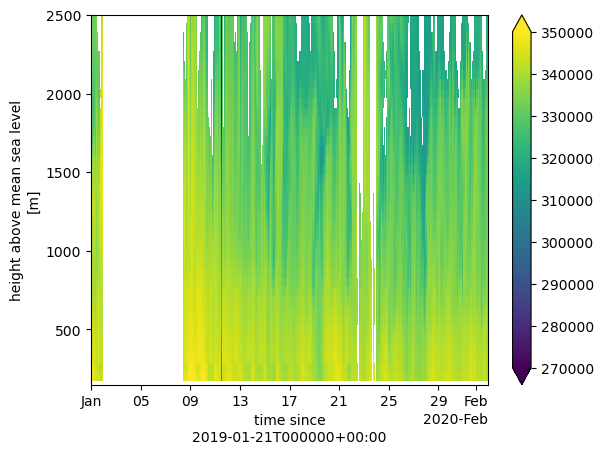

In [19]:
mse_coral.sel(time=slice("2020-01-01", "2020-02-01")).plot(vmin=270e3, vmax=350e3)
plt.ylim(150,2500)

In [54]:
x_vel = vel_sel.resample(time="1h").mean()
x_vel, mse_coral = xr.align(x_vel, mse_coral, join="inner")

(0.0, 2500.0)

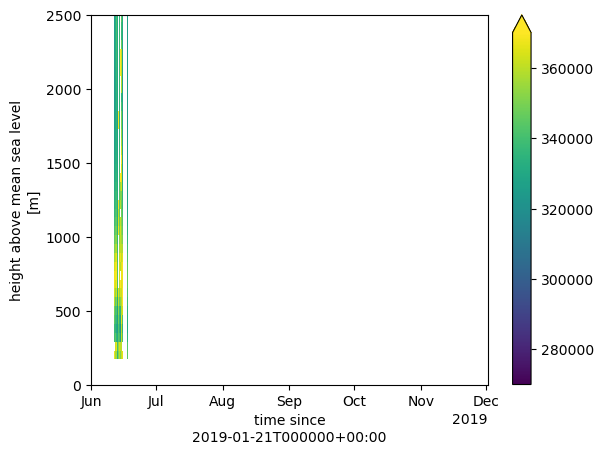

In [36]:
mse_coral.sel(time=slice("2019-06-01", "2019-12-01")).plot(vmin=270e3, vmax=370e3)
plt.gca().set_ylim(0,2500)

In [70]:
AS = [8, 9]
x_vel_as = x_vel.where(x_vel.time.dt.month.isin(AS), drop=True)
mse_coral_as = mse_coral.where(mse_coral.time.dt.month.isin(AS), drop=True)

quantile_ranges = {'low': [0.00, 0.10], 'mid': [0.45, 0.55], 'high': [0.90, 1.00]}
resulting_wind_bins_as = {'low': [], 'mid': [], 'high': []}
coral_mse_profiles_as = {}

for key, (q_low, q_high) in quantile_ranges.items():
    q_min, q_max = x_vel_as.quantile([q_low, q_high]).values
    resulting_wind_bins_as[key] = [q_min, q_max]
    mask = ((x_vel_as >= q_min) & (x_vel_as <= q_max)).compute()
    valid_times = x_vel_as.time.where(mask, drop=True)
    coral_mse_profiles_as[key] = mse_coral_as.sel(time=valid_times.values)

low_mse_prof_as = coral_mse_profiles_as['low']
mid_mse_prof_as = coral_mse_profiles_as['mid']
high_mse_prof_as = coral_mse_profiles_as['high']

In [71]:
JF = [1, 2]
x_vel_jf = x_vel.where(x_vel.time.dt.month.isin(JF), drop=True)
mse_coral_jf = mse_coral.where(mse_coral.time.dt.month.isin(JF), drop=True)

quantile_ranges = {'low': [0.00, 0.10], 'mid': [0.45, 0.55], 'high': [0.90, 1.00]}
resulting_wind_bins_jf = {'low': [], 'mid': [], 'high': []}
coral_mse_profiles_jf = {}

for key, (q_low, q_high) in quantile_ranges.items():
    q_min, q_max = x_vel_jf.quantile([q_low, q_high]).values
    resulting_wind_bins_jf[key] = [q_min, q_max]
    mask = ((x_vel_jf >= q_min) & (x_vel_jf <= q_max)).compute()
    valid_times = x_vel_jf.time.where(mask, drop=True)
    coral_mse_profiles_jf[key] = mse_coral_jf.sel(time=valid_times.values)

low_mse_prof_jf = coral_mse_profiles_jf['low']
mid_mse_prof_jf = coral_mse_profiles_jf['mid']
high_mse_prof_jf = coral_mse_profiles_jf['high']

Text(339, 1700, 'AS')

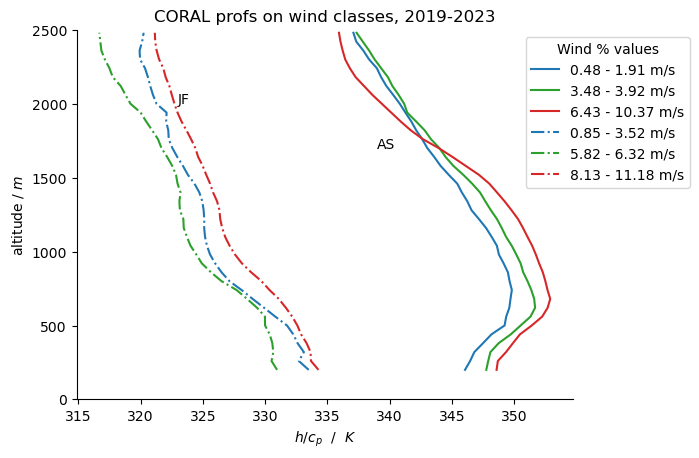

In [72]:
import matplotlib.lines as mlines

cols = {"low wind":"tab:blue",
        "mid wind":"tab:green",
        "high wind":"tab:red"}

(coral_mse_profiles_as['low']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["low"][0]:.2f} - {resulting_wind_bins_as["low"][1]:.2f} m/s", color=cols['low wind'])
(coral_mse_profiles_as['mid']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["mid"][0]:.2f} - {resulting_wind_bins_as["mid"][1]:.2f} m/s", color=cols["mid wind"])
(coral_mse_profiles_as['high']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["high"][0]:.2f} - {resulting_wind_bins_as["high"][1]:.2f} m/s", color=cols["high wind"])

(coral_mse_profiles_jf['low']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["low"][0]:.2f} - {resulting_wind_bins_jf["low"][1]:.2f} m/s", color=cols['low wind'], linestyle="-.")
(coral_mse_profiles_jf['mid']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["mid"][0]:.2f} - {resulting_wind_bins_jf["mid"][1]:.2f} m/s", color=cols["mid wind"], linestyle="-.")
(coral_mse_profiles_jf['high']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["high"][0]:.2f} - {resulting_wind_bins_jf["high"][1]:.2f} m/s", color=cols["high wind"], linestyle="-.")

plt.gca().set_ylim(0,2500)

for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

plt.gca().set_ylabel(r"altitude / $m$")
plt.gca().set_xlabel(r"$h/c_p$  /  $K$")
plt.gca().set_title("CORAL profs on wind classes, 2019-2023")

# handles = [mlines.Line2D([], [], color=color, label=label) for label, color in cols.items()]
# plt.gca().legend(handles=handles)
plt.gca().legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Wind % values")

plt.gca().text(323,2000,"JF")
plt.gca().text(339,1700,"AS")

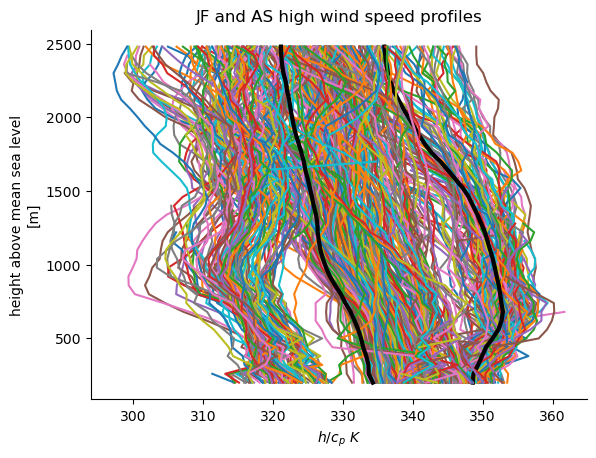

In [ ]:
fig, ax = plt.subplots(1,2)

(coral_mse_profiles_as['high']/cp).plot.line(ax=ax[0], y="alt", add_legend=False) 
(coral_mse_profiles_as['high']/cp).mean(dim="time").plot.line(ax=ax[0], y="alt", color="k", linewidth=3., add_legend=False)


(coral_mse_profiles_jf['high']/cp).plot.line(ax=ax[1], y="alt", add_legend=False) 
(coral_mse_profiles_jf['high']/cp).mean(dim="time").plot.line(ax=ax[1], y="alt", color="k", linewidth=3., add_legend=False)

for x in ax:
        for spine in ['top', 'right']:
                x.spines[spine].set_visible(False)

plt.gca().set_title("JF and AS high wind speed profiles")
plt.gca().set_xlabel(r"$h/c_p$ $K$")

plt.show()

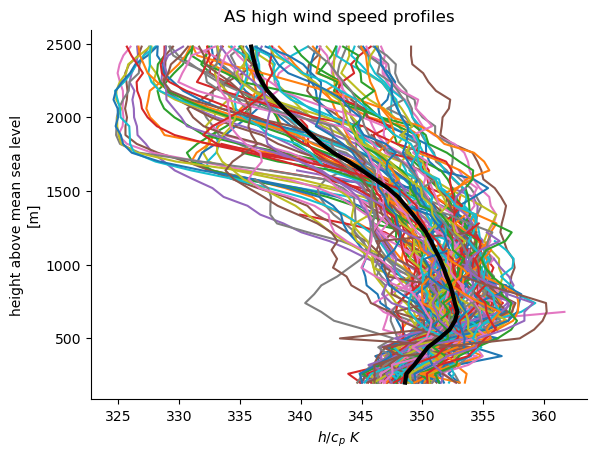

In [68]:
(coral_mse_profiles_as['high']/cp).plot.line(y="alt", add_legend=False)
(coral_mse_profiles_as['high']/cp).mean(dim="time").plot.line(y="alt", color="k", linewidth=3., add_legend=False)

for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

plt.gca().set_title("AS high wind speed profiles")
plt.gca().set_xlabel(r"$h/c_p$ $K$")

plt.show()

#### do same for LICHT lidar

In [73]:
licht1 = cat.BCO.lidar_LICHT_LR_t_c1_v1.to_dask()
licht1

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 1GB
Dimensions:    (alt: 251, lim: 2, time: 184320)
Coordinates:
  * alt        (alt) float32 1kB 20.0 80.0 140.0 ... 1.496e+04 1.502e+04
  * time       (time) datetime64[ns] 1MB 2016-07-17T00:02:00 ... 2017-06-14
Dimensions without coordinates: lim
Data variables:
    alt_bnds   (alt, lim) float32 2kB dask.array<chunksize=(251, 2), meta=np.ndarray>
    dtadz      (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    dtadz_err  (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    lat        float32 4B ...
    lon        float32 4B ...
    mr         (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    mr_err     (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    rh         (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    rh_err     (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    ta         (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
    ta_err     (time, alt) float32 185MB dask.array<chunksize=(27504, 124), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    calibration_version:          https://gitlab.gwdg.de/bco/calibration-rama...
    campaign:                     BCO
    detection_mode:               photoncounting
    ...                           ...
    start_time:                   2016-07-17T000200+00:00
    stop_time:                    2016-07-18T000000+00:00
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   7080.0
    title:                        water vapor, temperature, humidity, tempera...
    zenith_angle_degrees:         0.0

In [74]:
licht2 = cat.BCO.lidar_LICHT_LR_t_c2_v1.to_dask()
licht2 = licht2.sel(alt=slice(20, licht1.alt[-1].values))

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [75]:
licht = xr.concat([licht1, licht2], dim="time")
licht

/tmp/ipykernel_295131/514131617.py:1: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  licht = xr.concat([licht1, licht2], dim="time")


<xarray.Dataset> Size: 6GB
Dimensions:    (time: 575280, alt: 251, lim: 2)
Coordinates:
  * time       (time) datetime64[ns] 5MB 2016-07-17T00:02:00 ... 2019-12-07
  * alt        (alt) float32 1kB 20.0 80.0 140.0 ... 1.496e+04 1.502e+04
Dimensions without coordinates: lim
Data variables:
    alt_bnds   (time, alt, lim) float32 1GB dask.array<chunksize=(184320, 251, 2), meta=np.ndarray>
    dtadz      (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    dtadz_err  (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    lat        (time) float32 2MB 13.16 13.16 13.16 13.16 ... 13.16 13.16 13.16
    lon        (time) float32 2MB -59.43 -59.43 -59.43 ... -59.43 -59.43 -59.43
    mr         (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    mr_err     (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    rh         (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    rh_err     (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    ta         (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
    ta_err     (time, alt) float32 578MB dask.array<chunksize=(27504, 121), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    calibration_version:          https://gitlab.gwdg.de/bco/calibration-rama...
    campaign:                     BCO
    detection_mode:               photoncounting
    ...                           ...
    start_time:                   2016-07-17T000200+00:00
    stop_time:                    2016-07-18T000000+00:00
    temporal_resolution_seconds:  120.0
    temporal_smoothing_seconds:   7080.0
    title:                        water vapor, temperature, humidity, tempera...
    zenith_angle_degrees:         0.0

In [76]:
lowest_level  = 150.   # m - select all data above this level, as CORAL sees above a certina height only
highest_level = 2500
altitude_mask = (licht.alt>lowest_level) & (licht.alt<highest_level)

# Extract variables
licht_mr, mr_err     = licht['mr'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level)) , licht['mr_err'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level))
licht_ta, ta_err     = licht['ta'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level)) , licht['ta_err'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level))
licht_rh, rh_err     = licht['rh'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level)) , licht['rh_err'].transpose('alt','time').where((licht.alt>lowest_level)&(licht.alt<highest_level))

# strange values in e.g. slice("2020-02-19T00:58:00", "2020-02-19T15:58:00")
# --- clean unreasonable values

accept_mask = (licht_mr>0.)&(licht_mr<25e-3)&(mr_err/licht_mr < 1e-2)&(licht_ta>220.)&(licht_ta<323)&(ta_err/licht_ta < 1e-2)

licht_mr = licht_mr.where(accept_mask)
licht_ta = licht_ta.where(accept_mask)
licht_rh = licht_rh.where(accept_mask)

In [77]:
mse_licht = cp*licht_ta + Lv*licht_mr + grav*licht_mr.alt
mse_licht = mse_licht.resample(time="1h").mean()

(150.0, 2500.0)

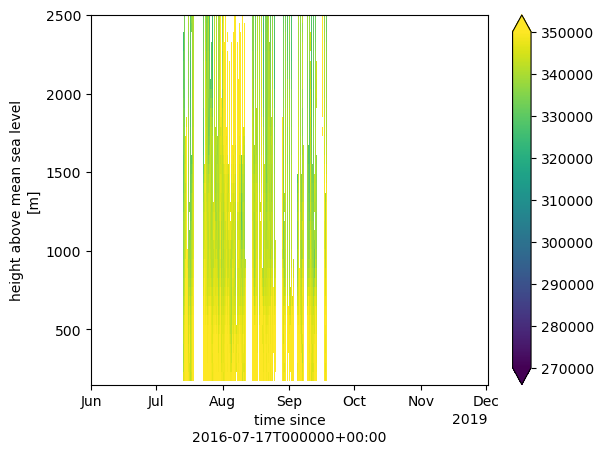

In [ ]:
mse_licht.sel(time=slice("2019-06-01", "2019-12-01")).plot(vmin=270e3, vmax=350e3)
plt.ylim(150,2500)

## general paucity of data here as well; worth remembering steep increse in june-aug 2018 in lower tropo MSE

In [78]:
## IMPORT wind velocity from wxt measurements above

x_vel = vel_sel.resample(time="1h").mean()
x_vel, mse_licht = xr.align(x_vel, mse_licht, join="inner")

(0.0, 2500.0)

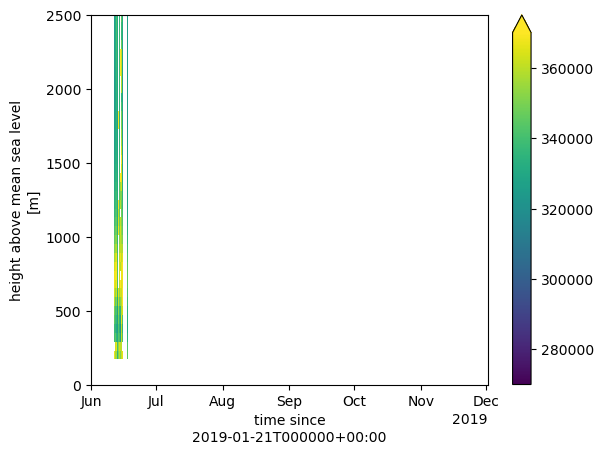

In [ ]:
mse_licht.sel(time=slice("2019-06-01", "2019-12-01")).plot(vmin=270e3, vmax=370e3)
plt.gca().set_ylim(0,2500)

In [80]:
AS = [8, 9]
x_vel_as = x_vel.where(x_vel.time.dt.month.isin(AS), drop=True)
mse_licht_as = mse_licht.where(mse_licht.time.dt.month.isin(AS), drop=True)

quantile_ranges = {'low': [0.00, 0.10], 'mid': [0.45, 0.55], 'high': [0.90, 1.00]}
resulting_wind_bins_as = {'low': [], 'mid': [], 'high': []}
licht_mse_profiles_as = {}

for key, (q_low, q_high) in quantile_ranges.items():
    q_min, q_max = x_vel_as.quantile([q_low, q_high]).values
    resulting_wind_bins_as[key] = [q_min, q_max]
    mask = ((x_vel_as >= q_min) & (x_vel_as <= q_max)).compute()
    valid_times = x_vel_as.time.where(mask, drop=True)
    licht_mse_profiles_as[key] = mse_licht_as.sel(time=valid_times.values)

low_mse_prof_as = licht_mse_profiles_as['low']
mid_mse_prof_as = licht_mse_profiles_as['mid']
high_mse_prof_as = licht_mse_profiles_as['high']

In [81]:
JF = [1, 2]
x_vel_jf = x_vel.where(x_vel.time.dt.month.isin(JF), drop=True)
mse_licht_jf = mse_licht.where(mse_licht.time.dt.month.isin(JF), drop=True)

quantile_ranges = {'low': [0.00, 0.10], 'mid': [0.45, 0.55], 'high': [0.90, 1.00]}
resulting_wind_bins_jf = {'low': [], 'mid': [], 'high': []}
licht_mse_profiles_jf = {}

for key, (q_low, q_high) in quantile_ranges.items():
    q_min, q_max = x_vel_jf.quantile([q_low, q_high]).values
    resulting_wind_bins_jf[key] = [q_min, q_max]
    mask = ((x_vel_jf >= q_min) & (x_vel_jf <= q_max)).compute()
    valid_times = x_vel_jf.time.where(mask, drop=True)
    licht_mse_profiles_jf[key] = mse_licht_jf.sel(time=valid_times.values)

low_mse_prof_jf = licht_mse_profiles_jf['low']
mid_mse_prof_jf = licht_mse_profiles_jf['mid']
high_mse_prof_jf = licht_mse_profiles_jf['high']

Text(339, 1700, 'AS')

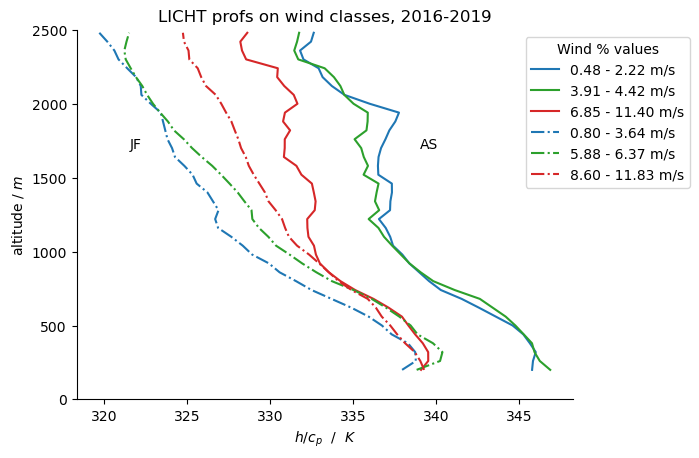

In [82]:
import matplotlib.lines as mlines

cols = {"low wind":"tab:blue",
        "mid wind":"tab:green",
        "high wind":"tab:red"}

(licht_mse_profiles_as['low']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["low"][0]:.2f} - {resulting_wind_bins_as["low"][1]:.2f} m/s", color=cols['low wind'])
(licht_mse_profiles_as['mid']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["mid"][0]:.2f} - {resulting_wind_bins_as["mid"][1]:.2f} m/s", color=cols["mid wind"])
(licht_mse_profiles_as['high']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_as["high"][0]:.2f} - {resulting_wind_bins_as["high"][1]:.2f} m/s", color=cols["high wind"])

(licht_mse_profiles_jf['low']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["low"][0]:.2f} - {resulting_wind_bins_jf["low"][1]:.2f} m/s", color=cols['low wind'], linestyle="-.")
(licht_mse_profiles_jf['mid']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["mid"][0]:.2f} - {resulting_wind_bins_jf["mid"][1]:.2f} m/s", color=cols["mid wind"], linestyle="-.")
(licht_mse_profiles_jf['high']/cp).mean(dim="time", skipna=True).plot.line(y="alt", label=f"{resulting_wind_bins_jf["high"][0]:.2f} - {resulting_wind_bins_jf["high"][1]:.2f} m/s", color=cols["high wind"], linestyle="-.")

plt.gca().set_ylim(0,2500)

for spine in ['top', 'right']:
        plt.gca().spines[spine].set_visible(False)

plt.gca().set_ylabel(r"altitude / $m$")
plt.gca().set_xlabel(r"$h/c_p$  /  $K$")
plt.gca().set_title("LICHT profs on wind classes, 2016-2019")

# handles = [mlines.Line2D([], [], color=color, label=label) for label, color in cols.items()]
# plt.gca().legend(handles=handles)
plt.gca().legend(loc="upper right", bbox_to_anchor=(1.25, 1), title="Wind % values")

plt.gca().text(321.5,1700,"JF")
plt.gca().text(339,1700,"AS")

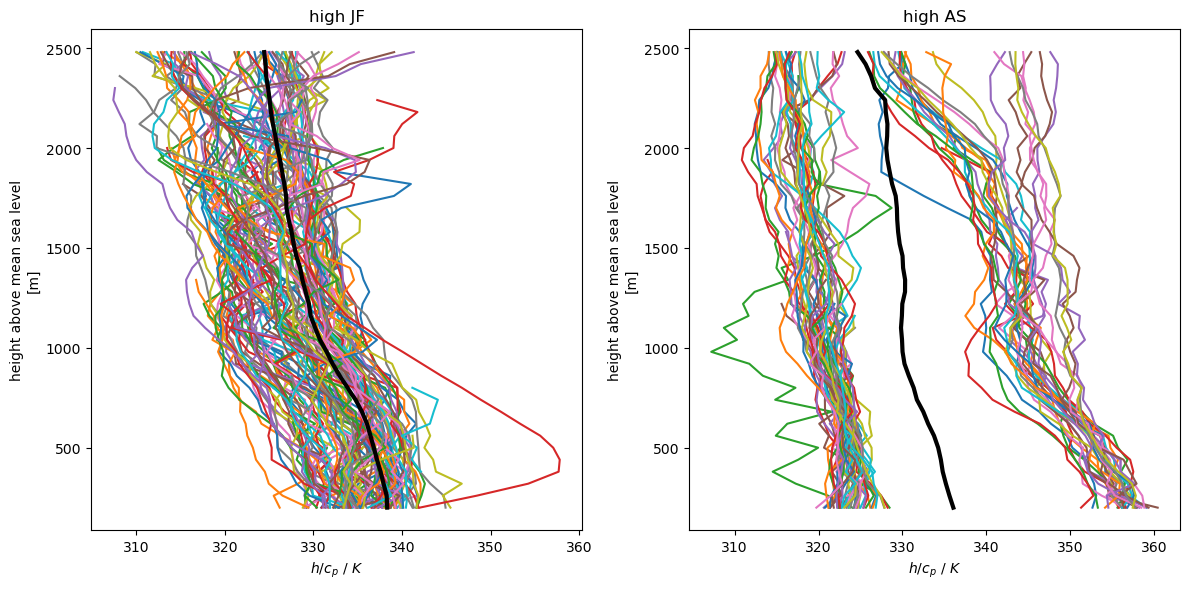

In [34]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
range = "high"

(licht_mse_profiles_jf[range]/cp).isel(time=slice(50,100)).plot.line(ax=ax[0], y="alt", add_legend=False)
(licht_mse_profiles_jf[range]/cp).isel(time=slice(225,275)).plot.line(ax=ax[0], y="alt", add_legend=False)
(licht_mse_profiles_jf[range]/cp).isel(time=slice(400,450)).plot.line(ax=ax[0], y="alt", add_legend=False)
(licht_mse_profiles_jf[range]/cp).mean(dim="time", skipna=True).plot.line(ax=ax[0], y="alt", color="k", linewidth=3.)
ax[0].set_title(range+" JF")
ax[0].set_xlabel(r"$h/c_p$ / $K$")


(licht_mse_profiles_as[range]/cp).isel(time=slice(50,100)).plot.line(ax=ax[1], y="alt", add_legend=False)
(licht_mse_profiles_as[range]/cp).isel(time=slice(225,275)).plot.line(ax=ax[1], y="alt", add_legend=False)
(licht_mse_profiles_as[range]/cp).isel(time=slice(400,450)).plot.line(ax=ax[1], y="alt", add_legend=False)
(licht_mse_profiles_as[range]/cp).mean(dim="time", skipna=True).plot.line(ax=ax[1], y="alt", color="k", linewidth=3.)
ax[1].set_title(range+" AS")
ax[1].set_xlabel(r"$h/c_p$ / $K$")

plt.tight_layout()
plt.show()




#### there is definitely something wrong 

In [28]:
print(np.unique((licht_mse_profiles_as['mid']/cp).isel(time=slice(50,100)).time.dt.year.values))
print(np.unique((licht_mse_profiles_as['mid']/cp).isel(time=slice(225,275)).time.dt.year.values))
print(np.unique((licht_mse_profiles_as['mid']/cp).isel(time=slice(400,450)).time.dt.year.values))


[2016]
[2017]
[2018 2019]


#### do the same with ERLI

In [45]:
earli = cat.BCO.lidar_EARLI_LR_b_c2_v1.to_dask()
earli

/work/mh1498/m301248/conda/envs/env_hacka/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 10GB
Dimensions:     (alt: 251, lim: 2, time: 813189)
Coordinates:
  * alt         (alt) float32 1kB 20.0 80.0 140.0 ... 1.496e+04 1.502e+04
  * time        (time) datetime64[ns] 7MB 2010-04-07T00:04:00 ... 2014-09-23
Dimensions without coordinates: lim
Data variables: (12/14)
    alt_bnds    (alt, lim) float32 2kB dask.array<chunksize=(251, 2), meta=np.ndarray>
    bp355       (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    bp355_err   (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    bp532       (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    bp532_err   (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    cloud_mask  (time, alt) float64 2GB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    ...          ...
    dv532       (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    dv532_err   (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    lat         float32 4B ...
    lon         float32 4B ...
    mr          (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
    mr_err      (time, alt) float32 816MB dask.array<chunksize=(64800, 51), meta=np.ndarray>
Attributes: (12/20)
    Conventions:                  CF-1.7
    altitude_meter_asl:           20.0
    calendar:                     gregorian
    campaign:                     BCO
    detection_mode:               photoncounting
    evaluation_method:            Raman
    ...                           ...
    start_time:                   2010-04-07T000200+00:00
    stop_time:                    2010-04-07T235800+00:00
    temporal_resolution_seconds:  120
    temporal_smoothing_seconds:   120.0
    title:                        water vapor, backscatter, depolarization, c...
    zenith_angle_degrees:         0.0